In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 50)
#pd.set_option('display.max_rows', 100)

def blight_model():
    
    # Your code here
    
    return # Your answer here

In [3]:
# Utils functions

# 1 / Verif function (print accuracy, precision, recall, F1, etc. for an algo)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix

def show_model_accuracy(algo_name, model, pX_test, py_test, do_plot = False):
    predicted = model.predict(pX_test)
    confusion = confusion_matrix(py_test, predicted)
    fpr, tpr, thresholds = roc_curve(py_test, predicted)
    roc_auc = auc(fpr, tpr)
    
    # Infos
    print('----------------------------------------------------------')
    print('Results for algorithm : ' + algo_name)
    print('----------------------------------------------------------\n')
    print('Confusion Matrix\n', confusion)
    print('Accuracy: {:.2f}'.format(accuracy_score(py_test, predicted)))
    print('Precision: {:.2f}'.format(precision_score(py_test, predicted)))
    print('Recall: {:.2f}'.format(recall_score(py_test, predicted)))
    print('F1: {:.2f}'.format(f1_score(py_test, predicted)))
    print('AUC: {:.2f}'.format(roc_auc))
    print('----------------------------------------------------------\n')
    
    # Plot ROC curve
    #if do_plot is not None && do_plot <> False :
    if do_plot:
        plt.title('Receiver Operating Characteristic (ROC Curve)')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

In [4]:
# 0 : Load data
df_train = pd.read_csv('train.csv', encoding='latin1')
df_test = pd.read_csv('test.csv', encoding='latin1')
df_addresses = pd.read_csv('addresses.csv', encoding='latin1')
df_latlons = pd.read_csv('latlons.csv', encoding='latin1')

# Join different datasets
new_df = pd.merge(df_train, df_addresses,  how='left', left_on=['ticket_id'], right_on = ['ticket_id'])
new_df2 = pd.merge(df_test, df_addresses,  how='left', left_on=['ticket_id'], right_on = ['ticket_id'])
df_train = pd.merge(new_df, df_latlons,  how='left', left_on=['address'], right_on = ['address'])
df_test = pd.merge(new_df2, df_latlons,  how='left', left_on=['address'], right_on = ['address'])

# Delete rows where there are no lat / lon (2 only)
df_train = df_train.dropna(subset=['lat', 'lon'])
df_test = df_train.dropna(subset=['lat', 'lon'])

/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
# ==================== 2 : Pre-processing ==================== 
# Remove Null values (not taken into account for the tests
df_train = df_train[df_train.compliance.notnull()]
df_train = df_train[df_train.hearing_date.notnull()]

# Add features
df_train['ticket_issued_date'] = df_train['ticket_issued_date'].astype('datetime64[ns]')
df_train['hearing_date'] = df_train['hearing_date'].astype('datetime64[ns]')
df_train['date_diff'] = df_train['hearing_date'].sub(df_train['ticket_issued_date'], axis=0)
df_train.date_diff = df_train.date_diff.dt.days

X = df_train[['agency_name','disposition','fine_amount','discount_amount','judgment_amount', 'lat', 'lon', 'admin_fee', 'state_fee', 'late_fee', 'clean_up_cost']]
y = df_train[['compliance']]

# create new features based on discrete values columns
X_dummies = pd.get_dummies(X, columns = ['agency_name', 'disposition'])

In [18]:
# split data for training
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, random_state=0)

# scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# ALGO : Dummy classifier
from sklearn.dummy import DummyClassifier
from sklearn.utils import check_X_y

# Reformat to avoid error
X_train_converted, y_train_converted = check_X_y(X=X_train_scaled, y=y_train)
X_test_converted, y_test_converted = check_X_y(X=X_test_scaled, y=y_test)

dummy_clf = DummyClassifier(strategy = 'most_frequent').fit(X_train_converted, y_train_converted)

show_model_accuracy('DummyClassifier - Train', dummy_clf, X_train_converted, y_train_converted)
show_model_accuracy('DummyClassifier - Test', dummy_clf, X_test_converted, y_test_converted)

/opt/conda/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


----------------------------------------------------------
Results for algorithm : DummyClassifier - Train
----------------------------------------------------------

Confusion Matrix
 [[111200      0]
 [  8538      0]]
Accuracy: 0.93
Precision: 0.00
Recall: 0.00
F1: 0.00
AUC: 0.50
----------------------------------------------------------

----------------------------------------------------------
Results for algorithm : DummyClassifier - Test
----------------------------------------------------------

Confusion Matrix
 [[37020     0]
 [ 2893     0]]
Accuracy: 0.93
Precision: 0.00
Recall: 0.00
F1: 0.00
AUC: 0.50
----------------------------------------------------------



/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
# ALGO : Random Forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=350, random_state=0, max_features='auto', max_depth=12, criterion='entropy', class_weight="balanced").fit(X_train_scaled, y_train)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


----------------------------------------------------------
Results for algorithm : RandomForestClassifier - Train
----------------------------------------------------------

Confusion Matrix
 [[100431  10769]
 [  3335   5203]]
Accuracy: 0.88
Precision: 0.33
Recall: 0.61
F1: 0.42
AUC: 0.76
----------------------------------------------------------



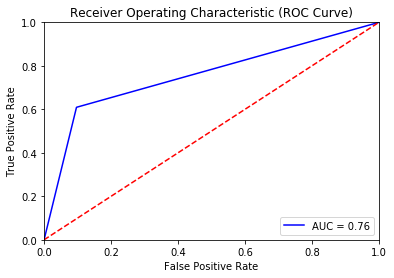

----------------------------------------------------------
Results for algorithm : RandomForestClassifier - Test
----------------------------------------------------------

Confusion Matrix
 [[33403  3617]
 [ 1257  1636]]
Accuracy: 0.88
Precision: 0.31
Recall: 0.57
F1: 0.40
AUC: 0.73
----------------------------------------------------------



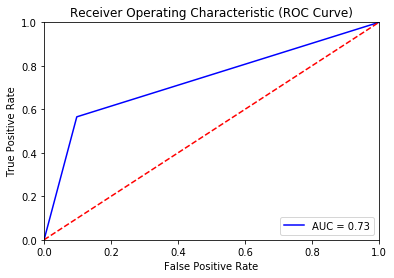

In [21]:
show_model_accuracy('RandomForestClassifier - Train', clf, X_train_scaled, y_train, True)
show_model_accuracy('RandomForestClassifier - Test', clf, X_test_scaled, y_test , True)

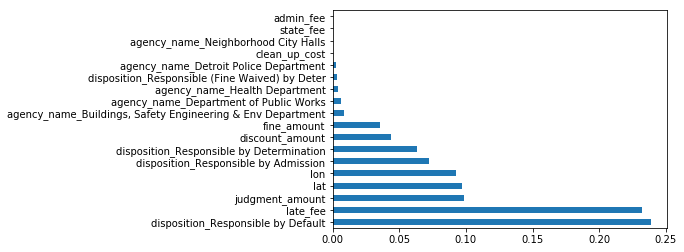

In [22]:
# View a list of the features and their importance scores
importances = clf.feature_importances_

feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()